In [1]:
class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()

    def get_sentiment(self):
        if (self.score >= 3):
            return "POSITIVE"
        else: 
            return "NEGATIVE"

### Extract data

In [2]:
import json

filename = "./data/sentiment/books_small_10000.json"

reviews = []
with open(filename) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall']))

print(reviews[1].text, reviews[1].score, reviews[1].sentiment)

I enjoyed this short book. But it was way way to short ....I can see how easily it would have been to add several chapters. 3.0 POSITIVE


### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

X = [x.text for x in reviews]
y = [y.sentiment for y in reviews]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 1)

### Tensorflow for neural network modeling

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

print(tf.__version__)

2.7.0


### Text preprocessing

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Tokenize and pad the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(X_train[0])
print(X_train_sequences[0])

max_len = max(len(seq) for seq in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen = max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

print(X_train_padded[0])

Of what's to come with Hunter and Brit.  All I will say is that this novella gets your heart going so that the only reasonable thing to do is buy the next installment of this great series!!
[6, 1252, 3, 200, 15, 1150, 2, 4579, 32, 5, 48, 156, 7, 12, 8, 768, 333, 92, 202, 125, 30, 12, 1, 98, 3033, 243, 3, 87, 7, 414, 1, 108, 649, 6, 8, 64, 58]
[ 0  0  0 ...  8 64 58]


In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode labels ('POSITIVE' and 'NEGATIVE') to numerical values (0 and 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### Train the model

In [7]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import regularizers

model = tf.keras.Sequential()

model.add(Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 50, input_length = max_len)) 
model.add(Dropout(0.5))
model.add(LSTM(units = 50))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss=losses.BinaryCrossentropy(from_logits=True), metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = model.fit(X_train_padded, y_train_encoded, epochs = 5, validation_split = 0.2)

Epoch 1/5


c:\Users\ADMIN\anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


168/168 [==============================] - 38s 94ms/step - loss: 0.2859 - binary_accuracy: 0.9323 - val_loss: 0.2107 - val_binary_accuracy: 0.9440
Epoch 2/5
107/168 [==================>...........] - ETA: 4s - loss: 0.2104 - binary_accuracy: 0.9314

### Plot the model's evaluation

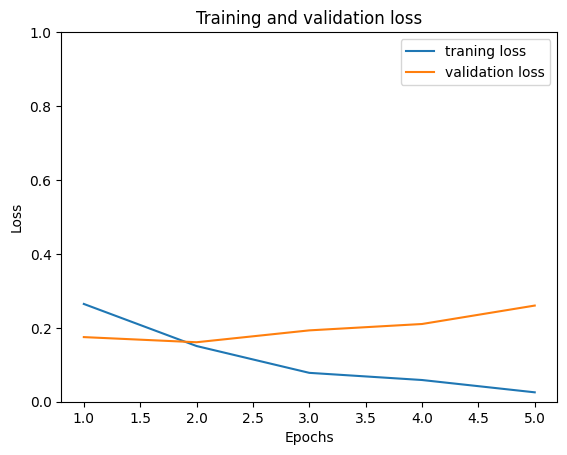

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label = 'traning loss')
plt.plot(epochs, history.history['val_loss'], label = 'validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

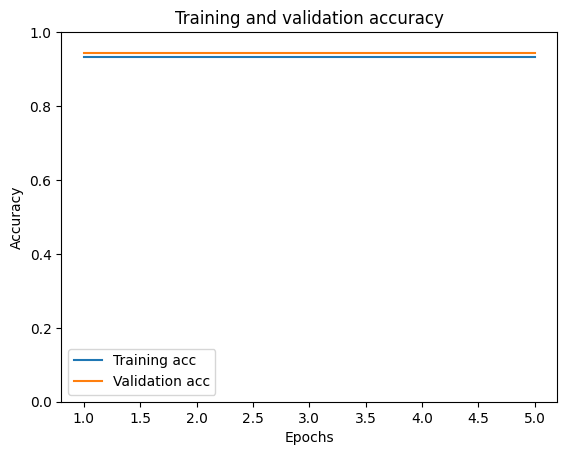

In [ ]:
plt.plot(epochs, history.history['binary_accuracy'], label='Training acc')
plt.plot(epochs, history.history['val_binary_accuracy'], label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

### Test

In [ ]:
def convert(p):
    if (p < 0.5): return 'NEGATIVE'
    else: return 'POSITIVE'
new_test = ['I hate this book', 'Bad book', 'trash book', 'Amazing book', 'This book is a masterpiece', 'What a waste of time']
new_test_sequences = tokenizer.texts_to_sequences(new_test)
new_test_padded = pad_sequences(new_test_sequences, maxlen=max_len)

predictions = [convert(p) for p in model.predict(new_test_padded)]
print(predictions)

['NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE']
